## Imports | DataFrames, images and arrays

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.filters import gaussian_filter

## Imports | PyTorch Neural Network

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

## Imports | Dataset and Transforms 

In [3]:
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

## Reading metadata

In [4]:
def reindex(df00):
    df00['Index'] = np.arange(len(df00['COVID-19']))
    df00 = df00.set_index('Index')
    return df00

In [5]:
#.....................................................................................................................
df = shuffle(pd.read_csv('pClassifyOneHot.csv')[['filename', 'COVID-19', 'Viral', 'Bacterial', 'Normal']])
df['Index'] = np.arange(len(df['COVID-19']))
df = df.set_index('Index')
print(df.shape[0],'Samples', 'and', df.shape[1]-1, 'Classes')
df.head()

504 Samples and 4 Classes


,filename,COVID-19,Viral,Bacterial,Normal
Index,,,,,
0,covid-19-pneumonia-7-L.jpg,1.0,0.0,0.0,0.0
1,person23_bacteria_81.jpeg,0.0,0.0,1.0,0.0
2,IM-0286-0001.jpeg,0.0,0.0,0.0,1.0
3,D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg,1.0,0.0,0.0,0.0
4,person151_virus_301.jpeg,0.0,1.0,0.0,0.0


## Train, test split

In [6]:
df_train, df_test = reindex(df.iloc[:int(504*0.7)]), reindex(df.iloc[int(504*0.7):])

/home/sumit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Preprocessing Functions

In [7]:
def imP(x):
    x = 2*gaussian_filter(cv2.equalizeHist(x),sigma = 5)
    return x*(x>np.mean(x)/2)

## Transforms to image tensor before training // Don't run again

In [8]:
IMtransform = transforms.Compose([transforms.Normalize, transforms.RandomCrop, transforms.RandomSizedCrop])

### Extending class torchvision.Dataset to make custom data-iterator

In [9]:
class MyDataLoader(Dataset):  
    
    def __init__(self, df, trans):
        
        super(MyDataLoader,self)
        self.df = df
        self.path = 'IMAGES/(1)'        
        self.transforms = trans
        
    def __getitem__(self,i):
        
        self.image = imP(cv2.imread(self.path+self.df['filename'][i])[:,:,0])
        self.image = Variable(torch.FloatTensor(self.image).cuda())
#"........................................................................................................................."        
        self.labels = Variable(torch.FloatTensor(df[['COVID-19', 'Viral', 'Bacterial', 'Normal']].iloc[i].values)).cuda() 
        return self.image.view(1,1,255,237)[0],self.labels
    
    def __len__(self):
        return len(df['filename'])

In [10]:
L0 = MyDataLoader(df_train,IMtransform)

## Loader

In [11]:
TrainLoader = torch.utils.data.DataLoader(dataset = L0, batch_size = 1, shuffle = False)
TrainLoader

## Check the TrainLoader iterator

In [12]:
for i,j in enumerate(TrainLoader):
    print(i,j[0].shape)
    if(i==5):
        break

0 torch.Size([1, 1, 255, 237])
1 torch.Size([1, 1, 255, 237])
2 torch.Size([1, 1, 255, 237])
3 torch.Size([1, 1, 255, 237])
4 torch.Size([1, 1, 255, 237])
5 torch.Size([1, 1, 255, 237])


## Defining the Neural Network

In [30]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 5, 3).cuda()
        self.conv2 = nn.Conv2d(5, 7, 5).cuda()
        self.conv3 = nn.Conv2d(7, 9, 3).cuda()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(504, 425).cuda()  # 6*6 from image dimension
        self.fc2 = nn.Linear(425, 350).cuda()
        self.fc3 = nn.Linear(350, 250).cuda()
        self.fc4 = nn.Linear(250, 200).cuda()
        self.fc5 = nn.Linear(200, 150).cuda()
        self.fc6 = nn.Linear(150, 100).cuda()
        self.fc7 = nn.Linear(100, 50).cuda()
        self.fc8 = nn.Linear(50, 4).cuda()

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 3).cuda()
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 3).cuda()
        x = F.max_pool2d(F.relu(self.conv3(x)), 3).cuda()
        
        x = x.view(-1, self.num_flat_features(x)).cuda()
        x = F.relu(self.fc1(x)).cuda()
        x = F.relu(self.fc2(x)).cuda()
        x = F.relu(self.fc3(x)).cuda()
        x = F.relu(self.fc4(x)).cuda()
        x = F.relu(self.fc5(x)).cuda()
        x = F.relu(self.fc6(x)).cuda()
        x = F.relu(self.fc7(x)).cuda()
        x = F.sigmoid(self.fc8(x).cuda())
        return x.cuda()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


## Object of class Net

In [31]:
myNet = Net().cuda()

In [32]:
myNet

Net(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 7, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(7, 9, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=504, out_features=425, bias=True)
  (fc2): Linear(in_features=425, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=250, bias=True)
  (fc4): Linear(in_features=250, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=150, bias=True)
  (fc6): Linear(in_features=150, out_features=100, bias=True)
  (fc7): Linear(in_features=100, out_features=50, bias=True)
  (fc8): Linear(in_features=50, out_features=4, bias=True)
)

## Optimizer and loss function

In [33]:
optimizer = torch.optim.Adam(myNet.parameters(), lr=0.01,weight_decay=0.0001)
criterion = nn.MSELoss()

## Training function

In [34]:
def train(n_epochs):
    
    for i in range(n_epochs):
        
        print('\n','Starting epoch', i)
        eloss = 0
        
        for u,(j,k)in enumerate(TrainLoader):

            optimizer.zero_grad()   # zero the gradient buffers
            
            output = myNet(j)
            loss = criterion(output, k)
            eloss+=loss
            losses.append(loss)
            loss.backward()
            optimizer.step()
            
            if(u==351):
                break
            
        print('Epoch: ',i, 'Loss', eloss/4)
        

## Call Training function

In [35]:
optimizer = torch.optim.Adam(myNet.parameters(), lr=0.01,weight_decay=0.0001)
losses = []
train(200)


 Starting epoch 0
Epoch:  0 Loss tensor(23.1024, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 1
Epoch:  1 Loss tensor(16.6930, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 2
Epoch:  2 Loss tensor(16.6343, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 3
Epoch:  3 Loss tensor(16.6208, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 4
Epoch:  4 Loss tensor(16.6123, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 5
Epoch:  5 Loss tensor(16.6054, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 6
Epoch:  6 Loss tensor(16.6001, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 7
Epoch:  7 Loss tensor(16.5952, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 8
Epoch:  8 Loss tensor(16.5914, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 9
Epoch:  9 Loss tensor(16.5880, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 10
Epoch:  10 Loss tensor(16.5850, device='cuda:0', grad_fn=<DivBackward0

Epoch:  89 Loss tensor(16.5450, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 90
Epoch:  90 Loss tensor(16.5420, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 91
Epoch:  91 Loss tensor(16.5510, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 92
Epoch:  92 Loss tensor(16.5401, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 93
Epoch:  93 Loss tensor(16.5373, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 94
Epoch:  94 Loss tensor(16.5366, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 95
Epoch:  95 Loss tensor(16.5362, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 96
Epoch:  96 Loss tensor(16.5677, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 97
Epoch:  97 Loss tensor(16.5341, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 98
Epoch:  98 Loss tensor(16.5355, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 99
Epoch:  99 Loss tensor(16.5359, device='cuda:0', grad_fn=<DivBackward0

Epoch:  176 Loss tensor(24.8196, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 177
Epoch:  177 Loss tensor(22.0072, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 178
Epoch:  178 Loss tensor(22.0002, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 179
Epoch:  179 Loss tensor(23.9749, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 180
Epoch:  180 Loss tensor(28.4455, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 181
Epoch:  181 Loss tensor(32.6250, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 182
Epoch:  182 Loss tensor(32.6250, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 183
Epoch:  183 Loss tensor(32.1316, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 184
Epoch:  184 Loss tensor(32.6250, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 185
Epoch:  185 Loss tensor(32.6250, device='cuda:0', grad_fn=<DivBackward0>)

 Starting epoch 186
Epoch:  186 Loss tensor(32.6250, device='cuda:0', 

In [ ]:
def train(n_epochs):
    
    for i in range(n_epochs):
        
        eloss = 0 
        
        for i,(j,k)in enumerate(TrainLoader):

            print('/n', 'epoch', u)
            
            optimizer.zero_grad()   # zero the gradient buffers
            
            output = myNet(j)
            loss = criterion(output, k)
            eloss+=loss
            losses.append(loss)
            loss.backward()
            optimizer.step()
            
        print('Epoch: ',i, 'Loss', eloss/4)

In [40]:
for i,(j,k) in enumerate(TrainLoader):
    print(myNet(j))
    break

tensor([[-10.4076,   1.7235,  -2.6707, -12.2058]], device='cuda:0',
       grad_fn=<AddmmBackward>)


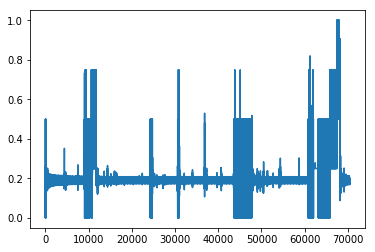

In [36]:
plt.plot(losses)

In [125]:
for i,(j,k) in enumerate(TrainLoader):
    q = j.view(1,1,255,237)
    print(newNet(q))
    break

tensor([[ 0.0042, -0.6371,  0.1450,  0.4376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
